In [ ]:
# Environment check and installs (if needed)
import sys
print('Python version:', sys.version)
# Try to import imblearn; if not installed, install it
try:
    import imblearn
    print('imblearn available:', imblearn.__version__)
except Exception as e:
    print('imblearn not available, installing...')
    !pip install -q imbalanced-learn
    import imblearn
    print('imblearn installed:', imblearn.__version__)

# Basic ML libraries
import sklearn, pandas as pd, numpy as np
print('sklearn', sklearn.__version__)
print('pandas', pd.__version__)
print('numpy', np.__version__)


Python version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
imblearn available: 0.14.0
sklearn 1.6.1
pandas 2.2.2
numpy 2.0.2


In [ ]:
# Load dataset
import pandas as pd
path = '/content/data-bank.csv'
df = pd.read_csv(path)
print('Dataset loaded from', path)
print('Shape:', df.shape)
df.head()

Dataset loaded from /content/data-bank.csv
Shape: (6819, 96)


,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


In [ ]:
# Quick inspection
df.info()
print('\nColumns:', list(df.columns))
# Show value counts for plausible target columns
candidates = ['bankruptcy', 'bankcuptcy', 'Bankrupt?', 'Bankrupt', 'BANKRUPT', 'Target']
for c in candidates:
    if c in df.columns:
        print(f"\nValue counts for {c}:")
        print(df[c].value_counts(dropna=False))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

In [ ]:
# Heuristics to detect target column
possible_target = None
for c in df.columns:
    # check for binary-like column
    if df[c].nunique() <= 3 and set(df[c].dropna().unique()).issubset({0,1,2,'0','1','2', 'Y','N','Yes','No', 'bankrupt', 'not bankrupt'}):
        possible_target = c
        break
# fallback: search for the word 'bank' and 'rupt' in column names
if possible_target is None:
    for c in df.columns:
        if 'bank' in c.lower() and 'rupt' in c.lower():
            possible_target = c
            break
# If still None, allow user to inspect manually
if possible_target is None:
    print('Could not auto-detect a clear binary target column. Please inspect the column names above and edit the notebook to set `target_col` accordingly.')
else:
    print('Guessed target column:', possible_target)
    print(df[possible_target].value_counts(dropna=False))
# We'll set target_col variable for subsequent steps (if guessed)
target_col = possible_target


Guessed target column: Bankrupt?
Bankrupt?
0    6599
1     220
Name: count, dtype: int64


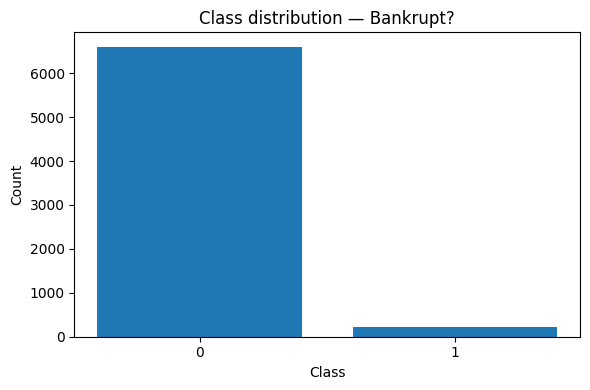


Top correlations (absolute) with target:


/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


,0
Net Income to Total Assets,0.315457
ROA(A) before interest and % after tax,0.282941
ROA(B) before interest and depreciation after tax,0.273051
ROA(C) before interest and depreciation before interest,0.260807
Debt ratio %,0.250161
Net worth/Assets,0.250161
Persistent EPS in the Last Four Seasons,0.219560
Retained Earnings to Total Assets,0.217779
Net profit before tax/Paid-in capital,0.207857
Per Share Net profit before tax (Yuan ¥),0.201395


<Figure size 600x400 with 0 Axes>

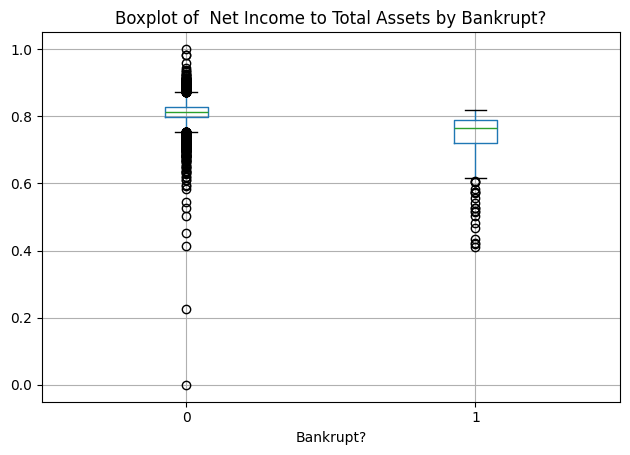

<Figure size 600x400 with 0 Axes>

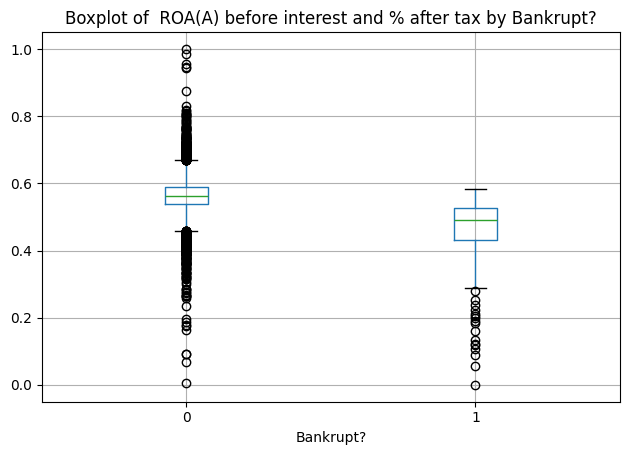

<Figure size 600x400 with 0 Axes>

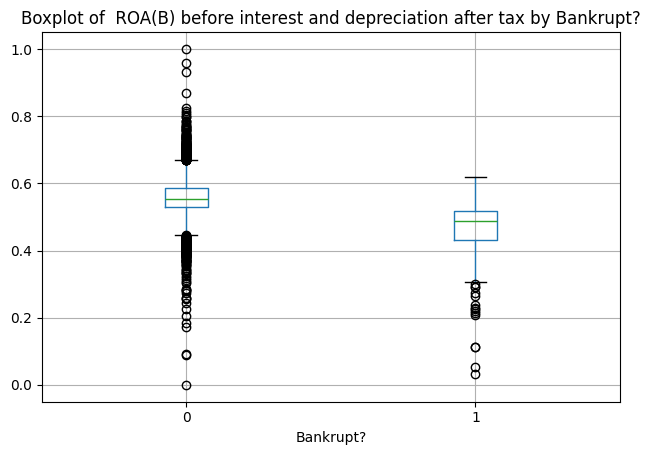

<Figure size 600x400 with 0 Axes>

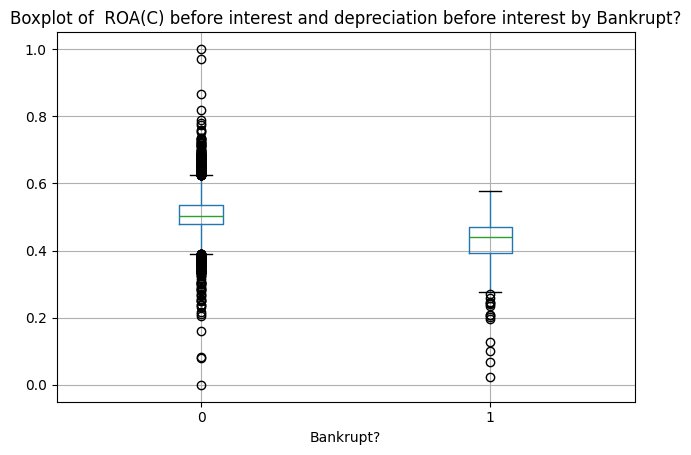

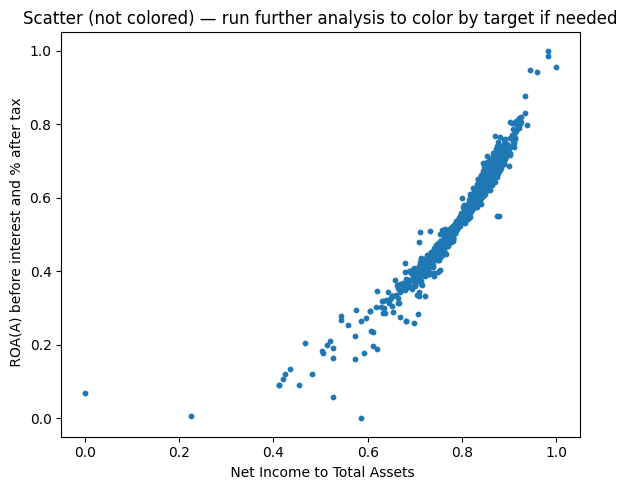

In [ ]:
# Exploratory Data Analysis (EDA) - distributions and relationships with target
import matplotlib.pyplot as plt
import numpy as np

# Use guessed target; if not found, raise informative message
if target_col is None:
    raise ValueError('Target column not set. Please open the notebook and set target_col manually to the column that indicates bankruptcy.')

# Show class distribution
plt.figure(figsize=(6,4))
values = df[target_col].value_counts()
plt.bar(values.index.astype(str), values.values)
plt.title('Class distribution — ' + target_col)
plt.xlabel('Class')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Show correlations for numeric features with target if target is numeric
# Convert target to numeric if possible
try:
    y_num = pd.to_numeric(df[target_col], errors='coerce')
    numeric = df.select_dtypes(include=[np.number]).columns.tolist()
    if target_col in numeric:
        numeric.remove(target_col)
    corrs = df[numeric].corrwith(y_num).abs().sort_values(ascending=False)
    print('\nTop correlations (absolute) with target:')
    display(corrs.head(15))
except Exception as e:
    print('Could not compute numeric correlations:', e)

# Plot top 4 features vs target (boxplots) if numeric
top_feats = corrs.head(4).index.tolist() if 'corrs' in locals() else []
for f in top_feats:
    plt.figure(figsize=(6,4))
    df.boxplot(column=f, by=target_col)
    plt.title(f'Boxplot of {f} by {target_col}')
    plt.suptitle('')
    plt.tight_layout()
    plt.show()

# Pairwise scatter for top 3 features colored by target
if len(top_feats) >= 2:
    plt.figure(figsize=(6,5))
    mask = df[target_col].notnull()
    plt.scatter(df.loc[mask, top_feats[0]], df.loc[mask, top_feats[1]], s=10)
    plt.xlabel(top_feats[0])
    plt.ylabel(top_feats[1])
    plt.title('Scatter (not colored) — run further analysis to color by target if needed')
    plt.tight_layout()
    plt.show()


In [ ]:
# Data Preparation: cleaning, encoding, scaling, handling imbalance
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Copy to avoid changing original
data = df.copy()

# Set target column (if auto-detected)
target = target_col
print('Using target:', target)

# Convert target to numeric 0/1 if possible
data[target] = pd.to_numeric(data[target], errors='coerce')
if set(data[target].dropna().unique()) - {0,1}:
    # try mapping common values
    mapping = {'Y':1,'Yes':1,'yes':1,'y':1,'Bankrupt':1,'bankrupt':1,'N':0,'No':0,'no':0,'Not Bankrupt':0}
    data[target] = data[target].replace(mapping)
data[target] = data[target].astype(int)

# Separate X and y
X = data.drop(columns=[target]).copy()
y = data[target].copy()

# Identify numeric and categorical
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]
print('Numeric cols:', len(num_cols), 'Categorical cols:', len(cat_cols))

# Impute numeric with median, categorical with mode
num_imp = SimpleImputer(strategy='median')
if num_cols:
    X[num_cols] = num_imp.fit_transform(X[num_cols])

if cat_cols:
    cat_imp = SimpleImputer(strategy='most_frequent')
    X[cat_cols] = cat_imp.fit_transform(X[cat_cols])
    # One-hot encode categorical
    X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# Feature scaling
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

print('Prepared feature matrix shape:', X_scaled.shape)


Using target: Bankrupt?
Numeric cols: 95 Categorical cols: 0
Prepared feature matrix shape: (6819, 95)


In [ ]:
# Check balance
from collections import Counter
print('Class distribution (train full):', Counter(y))

# We'll split first then apply SMOTE on training set to avoid leakage
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)
print('Train distribution before balancing:', Counter(y_train))

# Apply SMOTE if minority class is much smaller
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)
print('Train distribution after SMOTE:', Counter(y_train_bal))


Class distribution (train full): Counter({0: 6599, 1: 220})
Train distribution before balancing: Counter({0: 5279, 1: 176})
Train distribution after SMOTE: Counter({0: 5279, 1: 5279})


In [ ]:
# Modeling: Decision Tree, Random Forest, ANN (MLPClassifier)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, roc_auc_score, roc_curve, accuracy_score

models = {
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1),
    'ANN_MLP': MLPClassifier(hidden_layer_sizes=(64,32), max_iter=500, random_state=42)
}

fitted = {}
reports = {}
for name, model in models.items():
    print('\nTraining', name)
    model.fit(X_train_bal, y_train_bal)
    fitted[name] = model
    y_pred = model.predict(X_test)
    print('Accuracy:', accuracy_score(y_test, y_pred))
    print('Classification Report:\n', classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    print('Confusion Matrix:\n', cm)
    # store report
    reports[name] = {'y_pred': y_pred, 'cm': cm}



Training DecisionTree
Accuracy: 0.9288856304985337
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.94      0.96      1320
           1       0.23      0.52      0.32        44

    accuracy                           0.93      1364
   macro avg       0.61      0.73      0.64      1364
weighted avg       0.96      0.93      0.94      1364

Confusion Matrix:
 [[1244   76]
 [  21   23]]

Training RandomForest
Accuracy: 0.9611436950146628
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98      1320
           1       0.43      0.61      0.50        44

    accuracy                           0.96      1364
   macro avg       0.71      0.79      0.74      1364
weighted avg       0.97      0.96      0.96      1364

Confusion Matrix:
 [[1284   36]
 [  17   27]]

Training ANN_MLP
Accuracy: 0.9560117302052786
Classification Report:
               precision    reca

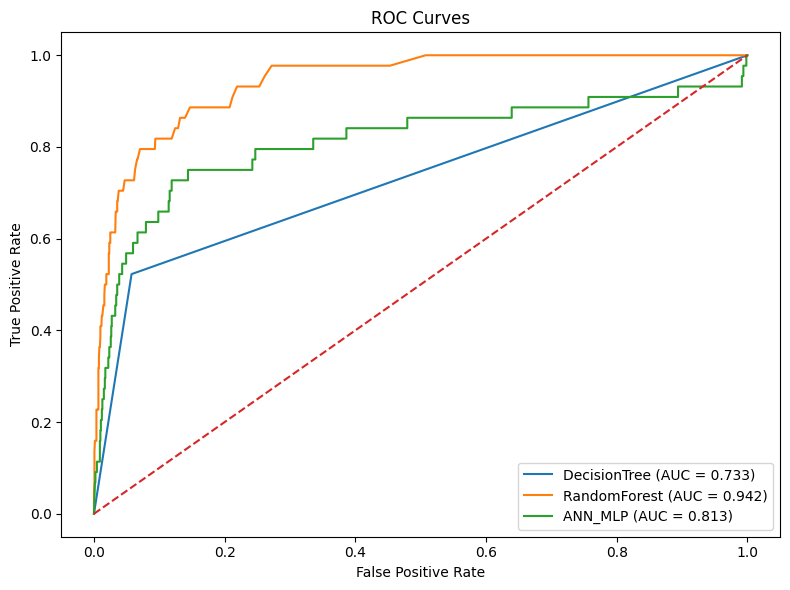

In [ ]:
# Detailed evaluation & ROC curves
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))

for name, model in fitted.items():
    if hasattr(model, 'predict_proba'):
        y_prob = model.predict_proba(X_test)[:,1]
    else:
        # use decision_function if no predict_proba
        try:
            y_prob = model.decision_function(X_test)
        except:
            y_prob = None
    if y_prob is not None:
        auc = roc_auc_score(y_test, y_prob)
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})')

plt.plot([0,1],[0,1],'--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Feature importance (Random Forest)
import numpy as np
rf = fitted.get('RandomForest', None)
if rf is not None:
    importances = rf.feature_importances_
    feat_imp = pd.Series(importances, index=X_train_bal.columns).sort_values(ascending=False)
    print('Top 20 feature importances from RandomForest:')
    display(feat_imp.head(20))
    top5 = feat_imp.head(5)
    print('\nTop 5 features likely most affecting bankruptcy:')
    print(top5)
else:
    print('RandomForest not trained.')

Top 20 feature importances from RandomForest:


,0
Borrowing dependency,0.079514
Net Income to Total Assets,0.051248
Persistent EPS in the Last Four Seasons,0.048271
Liability to Equity,0.041333
After-tax net Interest Rate,0.039813
Net worth/Assets,0.038382
Debt ratio %,0.035568
Continuous interest rate (after tax),0.030467
Net Income to Stockholder's Equity,0.028936
Total income/Total expense,0.027035



Top 5 features likely most affecting bankruptcy:
Borrowing dependency                       0.079514
Net Income to Total Assets                 0.051248
Persistent EPS in the Last Four Seasons    0.048271
Liability to Equity                        0.041333
After-tax net Interest Rate                0.039813
dtype: float64


In [ ]:
# Save important outputs
out = {}
if 'top5' in globals():
    out['top5_features'] = top5
    top5.to_csv('/content/top5_features.csv')
    print('Top 5 features saved to /content/top5_features.csv')

# Save final evaluation summary
summary = []
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
for name, info in reports.items():
    y_pred = info['y_pred']
    acc = accuracy_score(y_test, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', zero_division=0)
    summary.append({'model': name, 'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1})
summary_df = pd.DataFrame(summary).sort_values('f1', ascending=False)
summary_df.to_csv('/content/model_comparison_summary.csv', index=False)
print('Model comparison saved to /content/model_comparison_summary.csv')
display(summary_df)


Top 5 features saved to /content/top5_features.csv
Model comparison saved to /content/model_comparison_summary.csv


,model,accuracy,precision,recall,f1
1,RandomForest,0.961144,0.428571,0.613636,0.504673
2,ANN_MLP,0.956012,0.326087,0.340909,0.333333
0,DecisionTree,0.928886,0.232323,0.522727,0.321678


In [ ]:
print('Saved artifact locations:')
print('/content/bank_bankruptcy_analysis.ipynb  (this notebook file)')
print('/content/top5_features.csv')
print('/content/model_comparison_summary.csv')
print('\nYou can now download the .ipynb file from the environment.')

Saved artifact locations:
/content/bank_bankruptcy_analysis.ipynb  (this notebook file)
/content/top5_features.csv
/content/model_comparison_summary.csv

You can now download the .ipynb file from the environment.


In [ ]:
import pandas as pd

# Create a dictionary with values for a single new sample.
# All 95 features from the original X_scaled DataFrame must be present.
new_sample_data = {
    ' ROA(C) before interest and depreciation before interest': [0.015],
    ' ROA(A) before interest and % after tax': [0.02],
    ' ROA(B) before interest and depreciation after tax': [0.018],
    ' Operating Gross Margin': [0.12],
    ' Realized Sales Gross Margin': [0.11],
    ' Operating Profit Rate': [0.99],
    ' Pre-tax net Interest Rate': [0.75],
    ' After-tax net Interest Rate': [0.76],
    ' Non-industry income and expenditure/revenue': [0.30],
    ' Continuous interest rate (after tax)': [0.78],
    ' Operating Expense Rate': [0.05],
    ' Research and development expense rate': [0.0],
    ' Cash flow rate': [0.5],
    ' Interest-bearing debt interest rate': [0.001],
    ' Tax rate (A)': [0.0],
    ' Net Value Per Share (B)': [0.005],
    ' Net Value Per Share (A)': [0.005],
    ' Net Value Per Share (C)': [0.005],
    ' Persistent EPS in the Last Four Seasons': [0.001],
    ' Cash Flow Per Share': [0.002],
    ' Revenue Per Share (Yuan ¥)': [0.003],
    ' Operating Profit Per Share (Yuan ¥)': [0.001],
    ' Per Share Net profit before tax (Yuan ¥)': [0.001],
    ' Realized Sales Gross Profit Growth Rate': [0.001],
    ' Operating Profit Growth Rate': [0.001],
    ' After-tax Net Profit Growth Rate': [0.001],
    ' Regular Net Profit Growth Rate': [0.001],
    ' Continuous Net Profit Growth Rate': [0.001],
    ' Total Asset Growth Rate': [0.001],
    ' Net Value Growth Rate': [0.001],
    ' Total Asset Return Growth Rate Ratio': [0.001],
    ' Cash Reinvestment %': [0.5],
    ' Current Ratio': [0.1],
    ' Quick Ratio': [0.05],
    ' Interest Expense Ratio': [0.001],
    ' Total debt/Total net worth': [0.05],
    ' Debt ratio %': [0.05],
    ' Net worth/Assets': [0.95],
    ' Long-term fund suitability ratio (A)': [0.01],
    ' Borrowing dependency': [0.05],
    ' Contingent liabilities/Net worth': [0.0],
    ' Operating profit/Paid-in capital': [0.001],
    ' Net profit before tax/Paid-in capital': [0.001],
    ' Inventory and accounts receivable/Net value': [0.0],
    ' Total Asset Turnover': [0.01],
    ' Accounts Receivable Turnover': [0.01],
    ' Average Collection Days': [0.01],
    ' Inventory Turnover Rate (times)': [0.01],
    ' Fixed Assets Turnover Frequency': [0.01],
    ' Net Worth Turnover Rate (times)': [0.01],
    ' Revenue per person': [0.001],
    ' Operating profit per person': [0.001],
    ' Allocation rate per person': [0.001],
    ' Working Capital to Total Assets': [0.001],
    ' Quick Assets/Total Assets': [0.001],
    ' Current Assets/Total Assets': [0.001],
    ' Cash/Total Assets': [0.001],
    ' Quick Assets/Current Liability': [0.001],
    ' Cash/Current Liability': [0.001],
    ' Current Liability to Assets': [0.001],
    ' Operating Funds to Liability': [0.001],
    ' Inventory/Working Capital': [0.001],
    ' Inventory/Current Liability': [0.001],
    ' Current Liabilities/Liability': [0.001],
    ' Working Capital/Equity': [0.001],
    ' Current Liabilities/Equity': [0.001],
    ' Long-term Liability to Current Assets': [0.001],
    ' Retained Earnings to Total Assets': [0.001],
    ' Total income/Total expense': [0.001],
    ' Total expense/Assets': [0.001],
    ' Current Asset Turnover Rate': [0.001],
    ' Quick Asset Turnover Rate': [0.001],
    ' Working capitcal Turnover Rate': [0.001],
    ' Cash Turnover Rate': [0.001],
    ' Cash Flow to Sales': [0.001],
    ' Fixed Assets to Assets': [0.001],
    ' Current Liability to Liability': [0.001],
    ' Current Liability to Equity': [0.001],
    ' Equity to Long-term Liability': [0.001],
    ' Cash Flow to Total Assets': [0.001],
    ' Cash Flow to Liability': [0.001],
    ' CFO to Assets': [0.001],
    ' Cash Flow to Equity': [0.001],
    ' Current Liability to Current Assets': [0.001],
    ' Liability-Assets Flag': [0],
    ' Net Income to Total Assets': [0.05],
    ' Total assets to GNP price': [0.001],
    ' No-credit Interval': [0.6],
    ' Gross Profit to Sales': [0.6],
    " Net Income to Stockholder's Equity": [0.8],
    ' Liability to Equity': [0.05],
    ' Degree of Financial Leverage (DFL)': [0.02],
    ' Interest Coverage Ratio (Interest expense to EBIT)': [0.5],
    ' Net Income Flag': [1],
    ' Equity to Liability': [0.01]
}

# Create the DataFrame for the new sample
new_data = pd.DataFrame(new_sample_data, columns=X.columns) # Ensure columns match training data

# Jangan lupa lakukan scaling dengan scaler yang sudah dilatih
new_data_scaled = pd.DataFrame(scaler.transform(new_data), columns=new_data.columns)

# Pilih model terbaik (misal RandomForest)
best_model = fitted['RandomForest']

# Prediksi probabilitas dan kelas
pred_proba = best_model.predict_proba(new_data_scaled)[:, 1]
pred_class = best_model.predict(new_data_scaled)

print("=== HASIL PREDIKSI ===")
print("Probabilitas kebangkrutan:", pred_proba[0])
print("Prediksi kelas:", "Terancam Bangkrut" if pred_class[0] == 1 else "Sehat")

=== HASIL PREDIKSI ===
Probabilitas kebangkrutan: 0.39
Prediksi kelas: Sehat


In [ ]:
def predict_bank(model, scaler, base_sample, updates: dict):
    """base_sample = X.iloc[0], updates = dict kolom:value baru"""
    sample = base_sample.copy()
    for k,v in updates.items():
        if k in sample.index:
            sample[k] = v
    df = pd.DataFrame([sample])
    df_scaled = pd.DataFrame(scaler.transform(df), columns=df.columns)
    pred = model.predict(df_scaled)
    prob = model.predict_proba(df_scaled)[:,1]
    print("Prob kebangkrutan:", round(prob[0],3))
    print("Prediksi:", "⚠️ Bangkrut" if pred[0]==1 else "✅ Sehat")

predict_bank(
    fitted['RandomForest'],
    scaler,
    X.iloc[0],
    {
        ' ROA(C) before interest and depreciation before interest': 0.015,
        ' Operating Gross Margin': 0.12,
        ' Net Income to Total Assets': 0.05
    }
)


Prob kebangkrutan: 0.885
Prediksi: ⚠️ Bangkrut


In [ ]:
import pandas as pd


test_samples = [
    {
        ' ROA(C) before interest and depreciation before interest': 0.01,
        ' Operating Gross Margin': 7.05,
        ' Net Income to Total Assets': 0.02,
        ' Total debt/Total net worth': 0.8,
        ' Current Ratio': 0.3,
        ' Quick Ratio': 0.2,
        ' Interest Coverage Ratio (Interest expense to EBIT)': 0.1,
        ' Net Value Per Share (B)': 0.002,
        ' Cash Flow Per Share': 0.001,
        ' Cash Flow to Liability': 0.001,

    },
    {
        ' ROA(C) before interest and depreciation before interest': 0.05,
        ' Operating Gross Margin': 9.85,
        ' Net Income to Total Assets': 0.9,
        ' Total debt/Total net worth': 0.4,
        ' Current Ratio': 0.8,
        ' Quick Ratio': 0.6,
        ' Interest Coverage Ratio (Interest expense to EBIT)': 0.4,
        ' Net Value Per Share (B)': 0.075,
        ' Cash Flow Per Share': 8,
        ' Cash Flow to Liability': 0.004,
    },
    {
        ' ROA(C) before interest and depreciation before interest': 0.09,
        ' Operating Gross Margin': 0.25,
        ' Net Income to Total Assets': 0.15,
        ' Total debt/Total net worth': 0.1,
        ' Current Ratio': 2.5,
        ' Quick Ratio': 1.2,
        ' Interest Coverage Ratio (Interest expense to EBIT)': 0.9,
        ' Net Value Per Share (B)': 0.008,
        ' Cash Flow Per Share': 0.067,
        ' Cash Flow to Liability': 2.018,
    }
]


filled_samples = []
for sample in test_samples:
    s = {col: 0 for col in X.columns}
    s.update(sample)
    filled_samples.append(s)


new_data = pd.DataFrame(filled_samples, columns=X.columns)


new_data_scaled = pd.DataFrame(scaler.transform(new_data), columns=new_data.columns)


best_model = fitted['RandomForest']


pred_proba = best_model.predict_proba(new_data_scaled)[:, 1]
pred_class = best_model.predict(new_data_scaled)


results = pd.DataFrame({
    'Skenario': ['Bank Risiko Tinggi', 'Bank Rata-rata', 'Bank Sangat Sehat'],
    'Probabilitas Bangkrut': pred_proba,
    'Prediksi': ['⚠️ Bangkrut' if c == 1 else '✅ Sehat' for c in pred_class]
})

print("=== HASIL PENGUJIAN BEBERAPA BANK BARU ===")
display(results)


=== HASIL PENGUJIAN BEBERAPA BANK BARU ===


,Skenario,Probabilitas Bangkrut,Prediksi
0,Bank Risiko Tinggi,0.38,✅ Sehat
1,Bank Rata-rata,0.39,✅ Sehat
2,Bank Sangat Sehat,0.36,✅ Sehat
